In [1]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageOps, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import InputLayer, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow_hub as hub

In [2]:
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TF version: 2.5.0
GPU is available
Num GPUs Available:  1


In [3]:
def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# make some random data
reset_random_seeds()

# Loading the csv files

In [4]:
images_path = '../../data/pubfig83/'
filepath_train = '../../data/pubfig83/train.csv'
filepath_test = '../../data/pubfig83/test.csv'

# Data Exploration

In [5]:
df_train = pd.read_csv(filepath_train)
df_test = pd.read_csv(filepath_test)

print("train:" + str(df_train.shape))
print("test:" + str(df_test.shape))

train:(12178, 1)
test:(1660, 1)


In [6]:
df_train['face_name'] = df_train['image_pathname'].apply(lambda x: x.split('/')[1])
df_test['face_name'] = df_test['image_pathname'].apply(lambda x: x.split('/')[1])

In [7]:
df_train.head()

,image_pathname,face_name
0,imgs/Adam Sandler/277.jpg,Adam Sandler
1,imgs/Adam Sandler/136.jpg,Adam Sandler
2,imgs/Adam Sandler/198.jpg,Adam Sandler
3,imgs/Adam Sandler/234.jpg,Adam Sandler
4,imgs/Adam Sandler/202.jpg,Adam Sandler


In [8]:
df_train['face_name'].value_counts()

Miley Cyrus        347
Lindsay Lohan      334
Brad Pitt          280
Jessica Simpson    280
Avril Lavigne      279
                  ... 
Gordon Brown        82
Ashton Kutcher      81
Jack Nicholson      81
Robert Gates        80
Dustin Hoffman      80
Name: face_name, Length: 83, dtype: int64

In [9]:
print(list(np.sort(df_train['face_name'].unique())))

['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie', 'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne', 'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt', 'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron', 'Christina Ricci', 'Claudia Schiffer', 'Clive Owen', 'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo', 'Daniel Craig', 'Daniel Radcliffe', 'David Beckham', 'David Duchovny', 'Denise Richards', 'Drew Barrymore', 'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill', 'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson', 'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt', 'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix', 'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss', 'Kate Winslet', 'Katherine Heigl', 'Keira Knightley', 'Kiefer Sutherland', 'Leonardo DiCaprio', 'Lindsay Lohan', 'Mariah Carey', 'Martha Stewart', 'Matt Damon', 'Meg Ryan', 'Meryl Streep', '

In [10]:
df_test.head()

,image_pathname,face_name
0,imgs/Adam Sandler/34.jpg,Adam Sandler
1,imgs/Adam Sandler/236.jpg,Adam Sandler
2,imgs/Adam Sandler/127.jpg,Adam Sandler
3,imgs/Adam Sandler/111.jpg,Adam Sandler
4,imgs/Adam Sandler/216.jpg,Adam Sandler


In [11]:
df_test['face_name'].value_counts()

Uma Thurman        20
Mariah Carey       20
Alec Baldwin       20
Will Smith         20
Colin Farrell      20
                   ..
David Duchovny     20
Ricky Martin       20
Zac Efron          20
Ben Affleck        20
Joaquin Phoenix    20
Name: face_name, Length: 83, dtype: int64

In [12]:
print(list(np.sort(df_test['face_name'].unique())))

['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie', 'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne', 'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt', 'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron', 'Christina Ricci', 'Claudia Schiffer', 'Clive Owen', 'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo', 'Daniel Craig', 'Daniel Radcliffe', 'David Beckham', 'David Duchovny', 'Denise Richards', 'Drew Barrymore', 'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill', 'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson', 'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt', 'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix', 'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss', 'Kate Winslet', 'Katherine Heigl', 'Keira Knightley', 'Kiefer Sutherland', 'Leonardo DiCaprio', 'Lindsay Lohan', 'Mariah Carey', 'Martha Stewart', 'Matt Damon', 'Meg Ryan', 'Meryl Streep', '

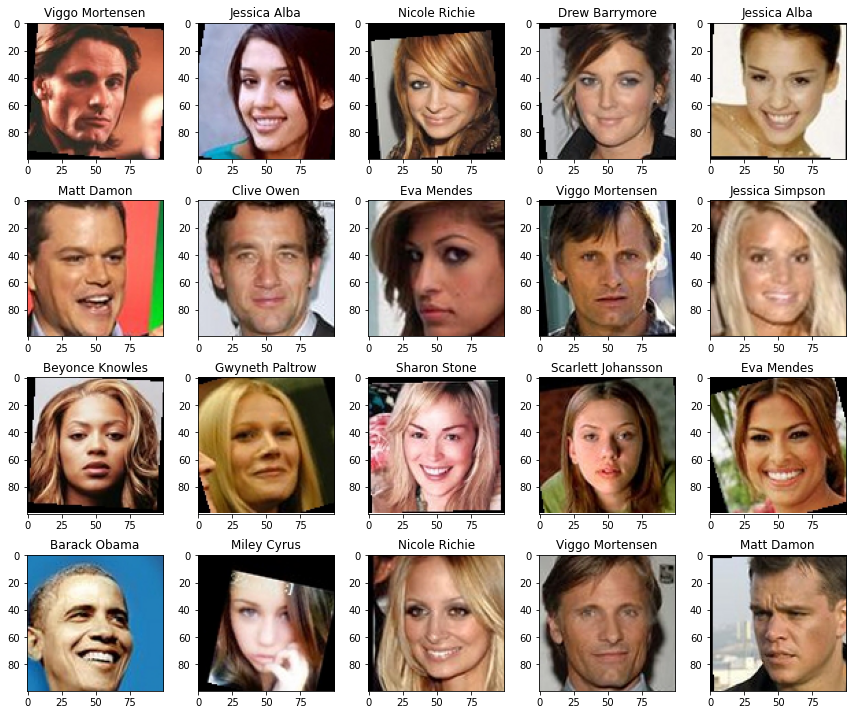

In [13]:
# Plotting a sample of the original train images:
plt.figure(figsize=(12, 10))

n_images = 20
for i in range(n_images):
    filename = df_train['image_pathname'].sample().values[0]
    image = Image.open(os.path.join(images_path, filename))
    # show the image
    plt.subplot(4, 5, i+1)
    plt.title(filename.split('/')[1])
    plt.imshow(image)

plt.tight_layout()
plt.show()

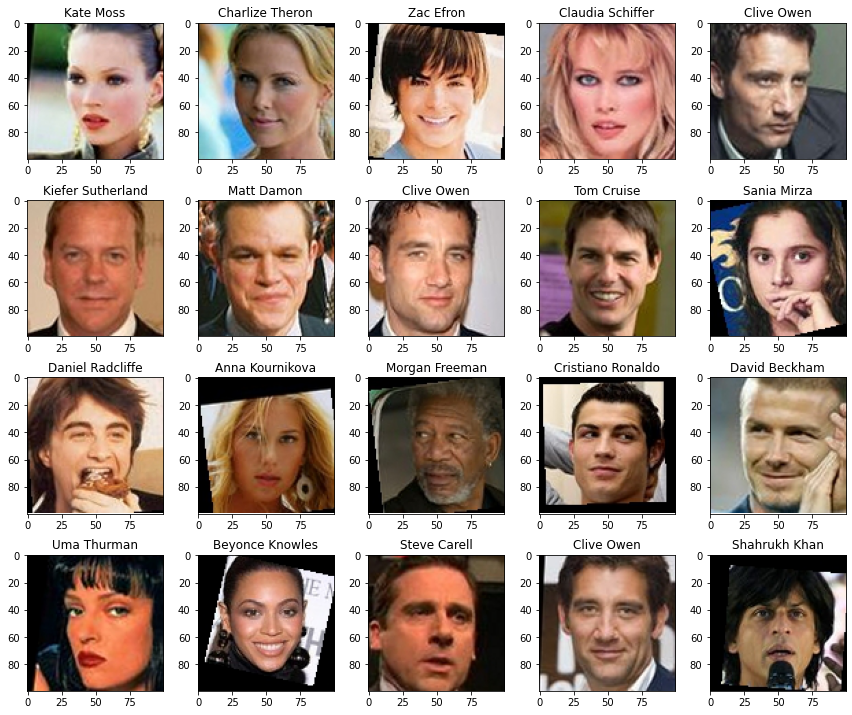

In [14]:
# Plotting a sample of the original test images:
plt.figure(figsize=(12, 10))

n_images = 20
for i in range(n_images):
    filename = df_test['image_pathname'].sample().values[0]
    image = Image.open(os.path.join(images_path, filename))
    # show the image
    plt.subplot(4, 5, i+1)
    plt.title(filename.split('/')[1])
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [15]:
# Train imagens size
img_sizes_train = []
for filename in df_train['image_pathname']:
    filepath = os.path.join(images_path, filename)
    image = Image.open(filepath)
    img_sizes_train.append(image.size)

img_sizes_train = pd.DataFrame(img_sizes_train, columns=['width', 'height'])
img_sizes_train.head()

,width,height
0,100,100
1,100,100
2,100,100
3,100,100
4,100,100


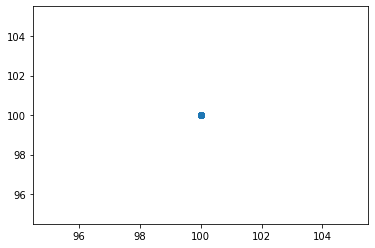

In [16]:
plt.figure()
plt.scatter(img_sizes_train['width'], img_sizes_train['height'], alpha=0.25)
plt.show()

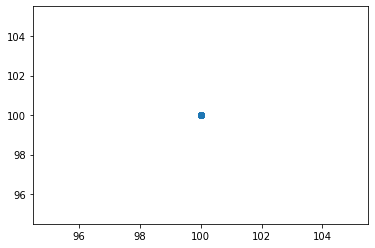

In [17]:
# Train imagens size
img_sizes_test = []
for filename in df_test['image_pathname']:
    filepath = os.path.join(images_path, filename)
    image = Image.open(filepath)
    img_sizes_test.append(image.size)
img_sizes_test = pd.DataFrame(img_sizes_test, columns=['width', 'height'])

plt.figure()
plt.scatter(img_sizes_test['width'], img_sizes_test['height'], alpha=0.25)
plt.show()

## Data Preparation

In [18]:
df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=42)

In [ ]:
batch_size = 128
target_size = (100, 100)

In [19]:
# Configuração da aumentação dos dados de treino:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

# Configuração da aumentação dos dados de teste:
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Criando o gerador que irá aumentar as fotos de treinamento:
train_generator = train_datagen.flow_from_dataframe(
                  dataframe=df_train,
                  directory=images_path,
                  x_col = 'image_pathname',
                  y_col = 'face_name',
                  color_mode='rgb',
                  batch_size=batch_size,
                  shuffle=True,
                  target_size=target_size,
                  class_mode='categorical',
                  seed=42,)

# Criando o gerador que irá lidar com as fotos de validação:
valid_generator = test_datagen.flow_from_dataframe(
                  dataframe=df_valid,
                  directory=images_path,
                  x_col = 'image_pathname',
                  y_col = 'face_name',
                  color_mode='rgb',
                  batch_size=batch_size,
                  shuffle=False,
                  target_size=target_size,
                  class_mode='categorical',
                  seed=42,)

# Criando o gerador que irá lidar com as fotos de test:
test_generator = test_datagen.flow_from_dataframe(
                 dataframe=df_test,
                 directory=images_path,
                 x_col = 'image_pathname',
                 y_col = 'face_name',
                 color_mode='rgb',
                 batch_size=1,
                 shuffle=False,
                 target_size=target_size,
                 class_mode=None,
                 seed=42,)

Found 8524 validated image filenames belonging to 83 classes.
Found 3654 validated image filenames belonging to 83 classes.
Found 1660 validated image filenames.


In [21]:
df_train['face_target'] = df_train['face_name'].apply(lambda x: train_generator.class_indices[x])
df_valid['face_target'] = df_valid['face_name'].apply(lambda x: train_generator.class_indices[x])
df_test['face_target'] = df_test['face_name'].apply(lambda x: train_generator.class_indices[x])

# Building the Baseline Model

In [22]:
n_classes = df_train['face_name'].nunique()

def build_model(input_shape=(100, 100, 3), n_classes=10):

    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))

    return model

model = build_model(input_shape=(target_size[0], target_size[1], 3), n_classes=n_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        1

In [23]:
learning_rate = 1e-4
patience = 10
model_tag = f'{datetime.now().year}-{datetime.now().month}-{datetime.now().day}-{datetime.now().hour}-{datetime.now().minute}-{datetime.now().second}'
weights_filepath = f"./weights/weights_{model_tag}.h5"

callbacks = [ModelCheckpoint(weights_filepath, monitor='val_acc', mode='max',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_acc', mode='max', patience=patience)]

# optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate)
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

## Treinamento do modelo:

In [24]:
epochs = 100
nb_train_samples = df_train.shape[0]
nb_validation_samples = df_valid.shape[0]

model.fit(train_generator,
          steps_per_epoch=int(nb_train_samples/batch_size),
          validation_data=valid_generator,
          validation_steps=int(nb_validation_samples/batch_size),
          epochs=epochs, callbacks=callbacks)

model.load_weights(weights_filepath)

Epoch 1/50
66/66 [==============================] - 30s 366ms/step - loss: 4.3749 - acc: 0.0231 - val_loss: 4.3829 - val_acc: 0.0318

Epoch 00001: val_acc improved from -inf to 0.03181, saving model to ./weights\weights_2022-6-18-9-52-28.h5
Epoch 2/50
66/66 [==============================] - 25s 377ms/step - loss: 4.3541 - acc: 0.0249 - val_loss: 4.3717 - val_acc: 0.0218

Epoch 00002: val_acc did not improve from 0.03181
Epoch 3/50
66/66 [==============================] - 24s 370ms/step - loss: 4.3429 - acc: 0.0258 - val_loss: 4.3617 - val_acc: 0.0312

Epoch 00003: val_acc did not improve from 0.03181
Epoch 4/50
66/66 [==============================] - 26s 395ms/step - loss: 4.3191 - acc: 0.0298 - val_loss: 4.3064 - val_acc: 0.0407

Epoch 00004: val_acc improved from 0.03181 to 0.04074, saving model to ./weights\weights_2022-6-18-9-52-28.h5
Epoch 5/50
66/66 [==============================] - 31s 472ms/step - loss: 4.2756 - acc: 0.0338 - val_loss: 4.2897 - val_acc: 0.0413

Epoch 00005: 

In [25]:
model_hist = pd.DataFrame(model.history.history)
model_hist.head()

,loss,acc,val_loss,val_acc
0,4.374935,0.023106,4.382898,0.031808
1,4.354080,0.024893,4.371718,0.021763
2,4.342879,0.025846,4.361681,0.031250
3,4.319082,0.029776,4.306351,0.040737
4,4.275590,0.033826,4.289699,0.041295


In [26]:
def plot_model_hist(historic, title=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.title(title+' loss')
    plt.plot(historic['loss'], label='train loss')
    plt.plot(historic['val_loss'], label='valid. loss')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.title(title+' acc')
    plt.plot(historic['acc'], label='train acc')
    plt.plot(historic['val_acc'], label='valid. acc')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.show()

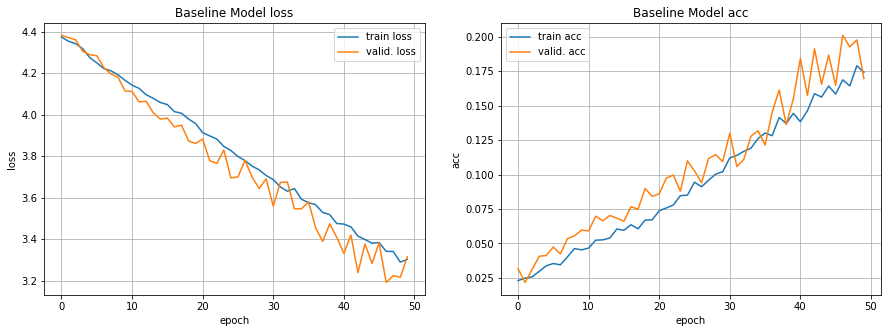

In [27]:
plot_model_hist(model_hist, 'Baseline Model')

## Making predictions:

In [28]:
steps=test_generator.n//test_generator.batch_size
test_generator.reset()

In [29]:
y_pred = model.predict(test_generator, steps=steps)
y_pred = np.argmax(y_pred, axis=1)

In [30]:
y_true = df_test['face_target'].values
print(classification_report(y_true, y_pred, target_names=[name for name in train_generator.class_indices.keys()]))

                      precision    recall  f1-score   support

        Adam Sandler       0.33      0.05      0.09        20
        Alec Baldwin       0.16      0.25      0.20        20
      Angelina Jolie       0.22      0.25      0.23        20
     Anna Kournikova       0.11      0.05      0.07        20
      Ashton Kutcher       0.56      0.25      0.34        20
       Avril Lavigne       0.23      0.45      0.31        20
        Barack Obama       0.23      0.85      0.37        20
         Ben Affleck       0.00      0.00      0.00        20
     Beyonce Knowles       0.00      0.00      0.00        20
           Brad Pitt       0.03      0.05      0.03        20
        Cameron Diaz       0.11      0.10      0.11        20
      Cate Blanchett       0.14      0.05      0.07        20
     Charlize Theron       0.00      0.00      0.00        20
     Christina Ricci       0.22      0.10      0.14        20
    Claudia Schiffer       0.50      0.05      0.09        20
       

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Building the Model 1

## Model preparation

In [19]:
model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384, "efficientnetv2-m": 480,
  "efficientnetv2-l": 480, "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240, "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300, "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480, "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512, "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240, "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300, "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480, "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512, "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240, "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,"efficientnet_b1": 240, "efficientnet_b2": 260,
  "efficientnet_b3": 300, "efficientnet_b4": 380,
  "efficientnet_b5": 456, "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299, "inception_resnet_v2": 299,
  "nasnet_large": 331, "pnasnet_large": 331,
}

In [20]:
model_name = "efficientnetv2-b0" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']
model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name)

print(f"Selected model: {model_name} : {model_handle}")

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2


## Building the model

In [21]:
target_size = (pixels, pixels)
batch_size = 128

print(f"Input size {target_size}")

Input size (224, 224)


In [25]:
n_classes = df_train['face_name'].nunique()

def build_model(input_shape=(100, 100, 3), n_classes=10, do_fine_tuning=False):
    input_shape = input_shape + (3,)
    
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(hub.KerasLayer(model_handle, trainable=do_fine_tuning))

    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))

    return model

model = build_model(input_shape=target_size, n_classes=n_classes, do_fine_tuning=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 83)                21331     
Total params: 6,268,579
Trainable params: 349,267
Non-trainable params: 5,919,312
_________________________________________________________________


## Treinamento do modelo:

In [26]:
epochs = 100
learning_rate = 1e-4
patience = 10

In [27]:
model_tag = f'{datetime.now().year}-{datetime.now().month}-{datetime.now().day}-{datetime.now().hour}-{datetime.now().minute}-{datetime.now().second}'
weights_filepath = f"./weights/weights_{model_tag}.h5"

callbacks = [ModelCheckpoint(weights_filepath, monitor='val_acc', mode='max',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_acc', mode='max', patience=patience)]

# optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate)
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [28]:
nb_train_samples = df_train.shape[0]
nb_validation_samples = df_valid.shape[0]

model.fit(train_generator,
          steps_per_epoch=int(nb_train_samples/batch_size),
          validation_data=valid_generator,
          validation_steps=int(nb_validation_samples/batch_size),
          epochs=epochs, callbacks=callbacks)

model.load_weights(weights_filepath)

Epoch 1/100
66/66 [==============================] - 112s 2s/step - loss: 4.3549 - acc: 0.0332 - val_loss: 4.2075 - val_acc: 0.0547

Epoch 00001: val_acc improved from -inf to 0.05469, saving model to ./weights\weights_2022-6-18-10-33-36.h5
Epoch 2/100
66/66 [==============================] - 100s 2s/step - loss: 4.1547 - acc: 0.0597 - val_loss: 4.0402 - val_acc: 0.0843

Epoch 00002: val_acc improved from 0.05469 to 0.08426, saving model to ./weights\weights_2022-6-18-10-33-36.h5
Epoch 3/100
66/66 [==============================] - 101s 2s/step - loss: 3.9903 - acc: 0.0838 - val_loss: 3.9011 - val_acc: 0.1004

Epoch 00003: val_acc improved from 0.08426 to 0.10045, saving model to ./weights\weights_2022-6-18-10-33-36.h5
Epoch 4/100
66/66 [==============================] - 109s 2s/step - loss: 3.8757 - acc: 0.1015 - val_loss: 3.7868 - val_acc: 0.1133

Epoch 00004: val_acc improved from 0.10045 to 0.11328, saving model to ./weights\weights_2022-6-18-10-33-36.h5
Epoch 5/100
66/66 [========

In [29]:
model_hist = pd.DataFrame(model.history.history)
model_hist.head()

,loss,acc,val_loss,val_acc
0,4.354889,0.033230,4.207524,0.054688
1,4.154730,0.059671,4.040168,0.084263
2,3.990338,0.083849,3.901133,0.100446
3,3.875730,0.101477,3.786837,0.113281
4,3.773914,0.117199,3.692040,0.125000


In [30]:
def plot_model_hist(historic, title=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.title(title+' loss')
    plt.plot(historic['loss'], label='train loss')
    plt.plot(historic['val_loss'], label='valid. loss')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.title(title+' acc')
    plt.plot(historic['acc'], label='train acc')
    plt.plot(historic['val_acc'], label='valid. acc')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.show()

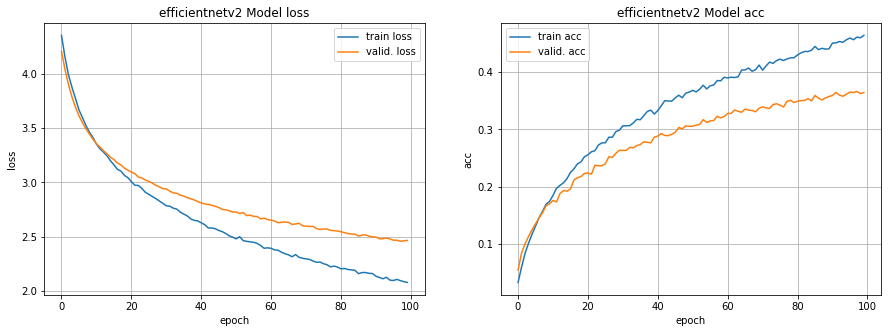

In [31]:
plot_model_hist(model_hist, 'efficientnetv2 Model')

## Making predictions:

In [32]:
steps=test_generator.n//test_generator.batch_size
test_generator.reset()

In [33]:
y_pred = model.predict(test_generator, steps=steps)
y_pred = np.argmax(y_pred, axis=1)

In [34]:
y_true = df_test['face_target'].values
print(classification_report(y_true, y_pred, target_names=[name for name in train_generator.class_indices.keys()]))

                      precision    recall  f1-score   support

        Adam Sandler       0.60      0.15      0.24        20
        Alec Baldwin       1.00      0.15      0.26        20
      Angelina Jolie       0.24      0.35      0.29        20
     Anna Kournikova       0.50      0.05      0.09        20
      Ashton Kutcher       0.38      0.50      0.43        20
       Avril Lavigne       0.21      0.80      0.34        20
        Barack Obama       0.33      0.65      0.43        20
         Ben Affleck       0.35      0.35      0.35        20
     Beyonce Knowles       0.24      0.25      0.24        20
           Brad Pitt       0.13      0.20      0.16        20
        Cameron Diaz       0.12      0.15      0.14        20
      Cate Blanchett       0.00      0.00      0.00        20
     Charlize Theron       0.21      0.15      0.18        20
     Christina Ricci       0.31      0.25      0.28        20
    Claudia Schiffer       1.00      0.20      0.33        20
       

# Building the Model 2

## Model preparation

In [19]:
# consider the original input shape: 224x224x4
base_model = VGG16(include_top=None, weights="imagenet", input_shape=(224, 224, 3))

## Building the model

In [20]:
target_size = (224, 224)
batch_size = 128

print(f"Input size {target_size}")

Input size (224, 224)


In [24]:
n_classes = df_train['face_name'].nunique()

def build_model(base_model, n_classes=10, do_fine_tuning=False):
    base_model.trainable = do_fine_tuning

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))

    return model

model = build_model(base_model, n_classes=n_classes, do_fine_tuning=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 83)                2

## Treinamento do modelo:

In [25]:
epochs = 200
learning_rate = 1e-4
patience = 10

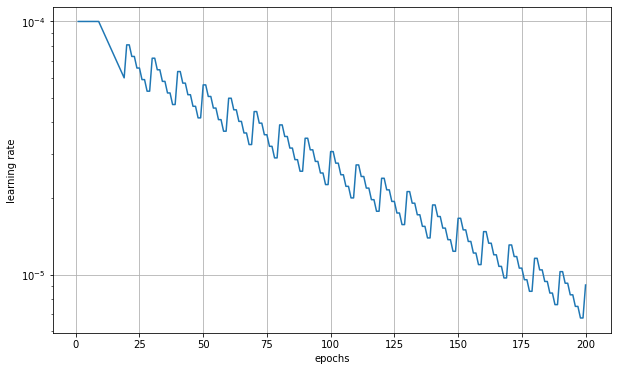

In [26]:
def scheduler(epoch, lr):
    if epoch < 10:
        pass
    elif epoch < 20:
        lr = lr*0.95
    elif epoch%2 == 0 and not epoch%10==0:
        lr = lr*0.9
    elif epoch%10== 0:
        lr = lr*1.35
    return max([lr, 1e-6])

def plot_lr_scheduler(scheduler, lr_start=1e-2, n_epochs=100):

    epochs_array = np.arange(1, n_epochs+1, 1)
    lr_array = [lr_start]
    for ep in epochs_array:
        lr_array.append(scheduler(ep, lr=lr_array[-1]))
    lr_array = lr_array[1:]

    plt.figure(figsize=(10,6))
    plt.plot(epochs_array, lr_array)
    plt.xlabel('epochs')
    plt.ylabel('learning rate')
    plt.yscale('log')
    plt.grid()
    plt.show()

plot_lr_scheduler(scheduler, lr_start=learning_rate, n_epochs=epochs)

In [27]:
model_tag = f'{datetime.now().year}-{datetime.now().month}-{datetime.now().day}-{datetime.now().hour}-{datetime.now().minute}-{datetime.now().second}'
weights_filepath = f"./weights/weights_{model_tag}.h5"

callbacks = [ModelCheckpoint(weights_filepath, monitor='val_acc', mode='max',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_acc', mode='max', patience=patience),
             LearningRateScheduler(scheduler, verbose=1)]

# optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate)
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [28]:
nb_train_samples = df_train.shape[0]
nb_validation_samples = df_valid.shape[0]

model.fit(train_generator,
          steps_per_epoch=int(nb_train_samples/batch_size),
          validation_data=valid_generator,
          validation_steps=int(nb_validation_samples/batch_size),
          epochs=epochs, callbacks=callbacks)

model.load_weights(weights_filepath)

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
66/66 [==============================] - 162s 2s/step - loss: 4.8404 - acc: 0.0206 - val_loss: 4.3750 - val_acc: 0.0379

Epoch 00001: val_acc improved from -inf to 0.03795, saving model to ./weights\weights_2022-6-18-21-25-19.h5
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
66/66 [==============================] - 119s 2s/step - loss: 4.3041 - acc: 0.0405 - val_loss: 4.2163 - val_acc: 0.0525

Epoch 00002: val_acc improved from 0.03795 to 0.05246, saving model to ./weights\weights_2022-6-18-21-25-19.h5
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
66/66 [==============================] - 125s 2s/step - loss: 4.1705 - acc: 0.0535 - val_loss: 4.0990 - val_acc: 0.0784

Epoch 00003: val_acc improved from 0.05246 to 0.07840, saving model to ./weights\weights_2022-6-18-21-25-19.h5
Epoch 4/200

Epo

In [29]:
model_hist = pd.DataFrame(model.history.history)
model_hist.head()

,loss,acc,val_loss,val_acc,lr
0,4.840386,0.020605,4.374974,0.037946,0.0001
1,4.304103,0.040495,4.216313,0.052455,0.0001
2,4.170459,0.053478,4.099048,0.078404,0.0001
3,4.042538,0.079204,3.931329,0.093750,0.0001
4,3.892413,0.094807,3.796584,0.113002,0.0001


In [30]:
def plot_model_hist(historic, title=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.title(title+' loss')
    plt.plot(historic['loss'], label='train loss')
    plt.plot(historic['val_loss'], label='valid. loss')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.title(title+' acc')
    plt.plot(historic['acc'], label='train acc')
    plt.plot(historic['val_acc'], label='valid. acc')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.show()

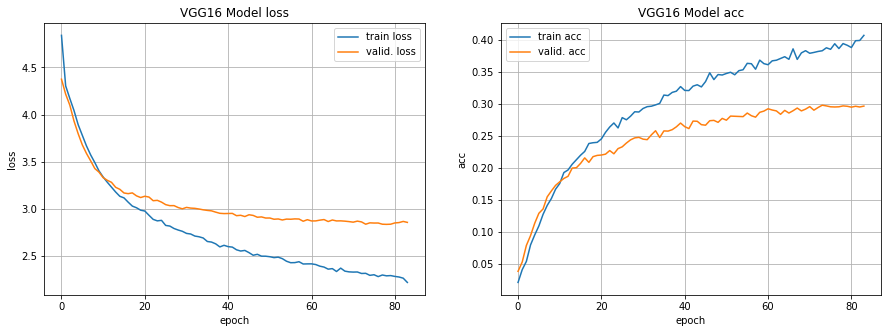

In [31]:
plot_model_hist(model_hist, 'VGG16 Model')

## Performing the Fine-Tuning process:

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 83)                2

In [40]:
base_model.trainable = True
n_layers = 3
count = 0
# Unfreezing the base-model last layers and freezing the :
for layer in base_model.layers[::-1]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization) and count < n_layers:
        layer.trainable = True
        count += 1
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 83)                2

In [41]:
epochs_ft = 100
learning_rate_ft = 1e-5
patience_ft = 10

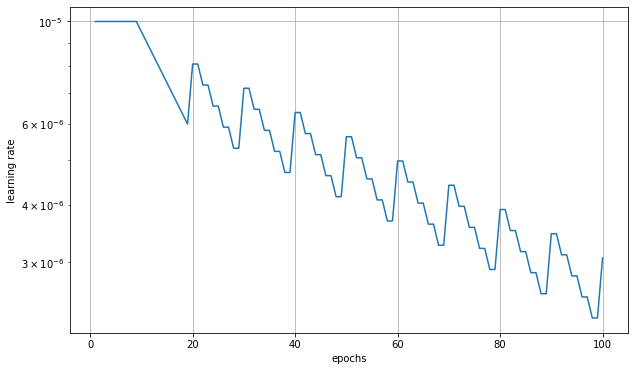

In [42]:
plot_lr_scheduler(scheduler, lr_start=learning_rate_ft, n_epochs=epochs_ft)

In [43]:
model_tag = f'{datetime.now().year}-{datetime.now().month}-{datetime.now().day}-{datetime.now().hour}-{datetime.now().minute}-{datetime.now().second}'
weights_filepath_ft= f"./weights/weights_{model_tag}.h5"

callbacks = [ModelCheckpoint(weights_filepath_ft, monitor='val_acc', mode='max',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_acc', mode='max', patience=patience_ft),
             LearningRateScheduler(scheduler, verbose=1)]

# optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate)
optimizer = Adam(learning_rate=learning_rate_ft)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [44]:
nb_train_samples = df_train.shape[0]
nb_validation_samples = df_valid.shape[0]

model.fit(train_generator,
          steps_per_epoch=int(nb_train_samples/batch_size),
          validation_data=valid_generator,
          validation_steps=int(nb_validation_samples/batch_size),
          epochs=epochs_ft, callbacks=callbacks)

model.load_weights(weights_filepath_ft)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
66/66 [==============================] - 106s 2s/step - loss: 2.0974 - acc: 0.4364 - val_loss: 2.7085 - val_acc: 0.3379

Epoch 00001: val_acc improved from -inf to 0.33789, saving model to ./weights\weights_2022-6-19-0-16-47.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
66/66 [==============================] - 107s 2s/step - loss: 2.0366 - acc: 0.4458 - val_loss: 2.7009 - val_acc: 0.3387

Epoch 00002: val_acc improved from 0.33789 to 0.33873, saving model to ./weights\weights_2022-6-19-0-16-47.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
66/66 [==============================] - 108s 2s/step - loss: 2.0049 - acc: 0.4539 - val_loss: 2.6329 - val_acc: 0.3516

Epoch 00003: val_acc improved from 0.33873 to 0.35156, saving model to ./weights\weights_2022-6-19-0-16-47.h5
Epoch 4/100

Epoch 

In [45]:
model_hist_ft = pd.DataFrame(model.history.history)
model_hist_ft.head()

,loss,acc,val_loss,val_acc,lr
0,2.097437,0.436398,2.708527,0.337891,0.00001
1,2.036558,0.445808,2.700917,0.338728,0.00001
2,2.004893,0.453907,2.632935,0.351562,0.00001
3,1.961257,0.460696,2.679470,0.347656,0.00001
4,1.927182,0.479871,2.616800,0.359933,0.00001


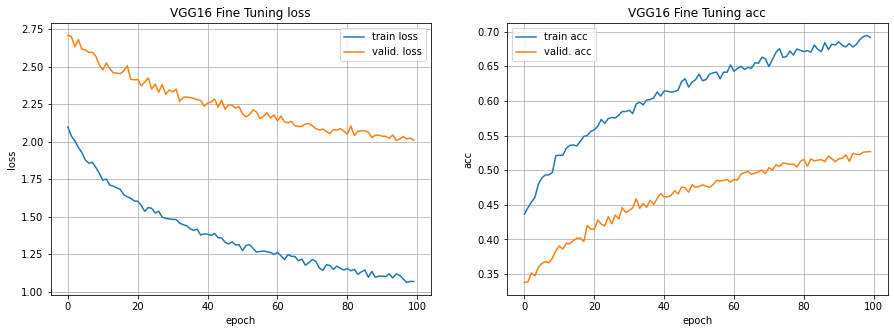

In [46]:
plot_model_hist(model_hist_ft, 'VGG16 Fine Tuning')

## Making predictions:

In [47]:
steps=test_generator.n//test_generator.batch_size
test_generator.reset()

In [48]:
y_pred = model.predict(test_generator, steps=steps)
y_pred = np.argmax(y_pred, axis=1)

In [49]:
y_true = df_test['face_target'].values
print(classification_report(y_true, y_pred, target_names=[name for name in train_generator.class_indices.keys()]))

                      precision    recall  f1-score   support

        Adam Sandler       0.67      0.30      0.41        20
        Alec Baldwin       0.64      0.35      0.45        20
      Angelina Jolie       0.41      0.35      0.38        20
     Anna Kournikova       0.50      0.25      0.33        20
      Ashton Kutcher       0.58      0.35      0.44        20
       Avril Lavigne       0.40      0.95      0.56        20
        Barack Obama       0.70      0.80      0.74        20
         Ben Affleck       0.67      0.60      0.63        20
     Beyonce Knowles       0.48      0.50      0.49        20
           Brad Pitt       0.50      0.40      0.44        20
        Cameron Diaz       0.38      0.60      0.46        20
      Cate Blanchett       0.21      0.20      0.21        20
     Charlize Theron       0.42      0.40      0.41        20
     Christina Ricci       0.46      0.30      0.36        20
    Claudia Schiffer       1.00      0.40      0.57        20
       

# Conclusion

#### Descrição Geral:
- Foi utilizado o ImageDataGenerator no pre-processamento das imagens, com modificações na imagem visando proporcionar a aumentação dos dados via rotação, inversão e zoom, etc.;
- No treinamento foi utilizado um Batch de 128 imagens;
- Foram utilizados os seguintes callbacks: ModelCheckpoint e EarlyStopping em todos os treinamentos;
- Otimizador Adam
- Todas as redes utilizaram camadas de Dropout;
- loss: categorical_crossentropy.

#### Descrição dos modelos:
- Baseline: Modelo simples com redes convolucionais, flatten e camadas densas. Treinado por 50 épocas
- Modelo 1: Neste caso foi utilizada a técnica de transfer learning com a rede efficientnetv2, adicionando apenas as camadas finais para a classifição (sem fine-tuning). Modelo Treinado por 100 épocas
- Modelo 2: Neste caso foi utilizada a técnica de transfer learning com a rede VGG16, adicionando uma camada de GlobalAveragePooling2D seguida de camadas densas classifição. Além da camada de dropout, também se utilizou um regularizador l2 na última camada. Foram realizados 2 etapas de treinamento: o primeiro sem fine-tuning por 200 épocas (interrompido na época 84 pelo early stopping). Na segunda etapa, com fine-tuning, as 3 últimas camadas da rede VGG16 foram treinadas juntamente com as camadas adicionadas, por 100 épocas.


Resumo do desempenho das redes: 

| Modelo   | Acc. Validação | Acc. Teste |
|----------|----------------|------------|
| Baseline | 0.2            | 0.19       |
| Modelo 1 | 0.37           | 0.35       |
| Modelo 2 | 0.53           | 0.51       |